In [1]:
#relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#momentum lib
from MomentumLibrary import *

#plotting
%matplotlib inline
sns.set()
shap.initjs()
%load_ext tensorboard

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


## Read and preprocess dataset

**1. The backtester expects a dataframe (representing a single asset) with:**
+ the columns **Price** and **Date**, (optional **High**, **Low**, **Open** and any others) 
+ the columns **Rate** and **Date** for a swap or STIR Future
+ set **swap=True**  if your asset is a swap or STIR future

**2. Add Exogenous Variables**

Read in another dataset and append relevant columns to your dataframe **df**

**3. Statistics**

Some summary statistics of the asset are produced; distributions; autocorrelation

**preprocessing - Feature Engineering**
What features are added to the asset dataset:
+ Apply log-transform to Price, High, Low, Open
+ Add day, weekday (Mon-Fri), month as one-hot variables
+ Add lagged features
+ Add Intraday Range:  $\text{log}(High/Low)$
+ Add Log-Returns : $\text{log}(Price_{t} / Price_{t-1}) $





ADDED FEATURES - COMPLETE
--------------------
ADDED FEATURES - COMPLETE
--------------------
HISTORICAL DATA STATISTICS
--------------------
Number of days: 1360
Data Start: 2015-01-02 00:00:00
Data End: 2020-04-09 00:00:00
--------------------
Tests for Normality
--------------------
Mean Returns: -0.000090%
Std Dev of Returns (Vol): 0.025710
Skew of Returns (Vol): 0.090565
Kurtosis of Returns (Normal 3): 12.268862
--------------------
Mean Log-Returns: -0.000421
Std Dev of Log-Returns (Vol): 0.025806
Skew of Log Returns: -0.5011824943443197
Kurtosis of Log Returns: 14.657915077540927
--------------------
Tests for Stationarity:
--------------------
Test for stationarity of returns: p-value - 0.00000
Test for stationarity of price: p-value - 0.49325
Test for stationarity of log_returns: p-value - 0.00000
--------------------


,Date,Price,High,Low,US_5_Year_Log_Returns,log_returns,IntradayRange,month,day,weekday
1355,2020-04-03,3.529591,3.555348,3.341093,0.002743,0.130395,0.214255,4,3,4
1356,2020-04-06,3.498022,3.533395,3.402197,0.003190,-0.031569,0.131198,4,6,0
1357,2020-04-07,3.461665,3.531641,3.457578,0.006049,-0.036356,0.074063,4,7,1
1358,2020-04-08,3.491647,3.522530,3.451257,0.003462,0.029982,0.071273,4,8,2
1359,2020-04-09,3.460095,3.594019,3.445533,0.001576,-0.031552,0.148486,4,9,3


,Date,Price,High,Low,US_5_Year_Log_Returns,log_returns,IntradayRange,month_2,month_3,month_4,...,day_26,day_27,day_28,day_29,day_30,day_31,weekday_1,weekday_2,weekday_3,weekday_4
1355,2020-04-03,3.529591,3.555348,3.341093,0.002743,0.130395,0.214255,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1356,2020-04-06,3.498022,3.533395,3.402197,0.003190,-0.031569,0.131198,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1357,2020-04-07,3.461665,3.531641,3.457578,0.006049,-0.036356,0.074063,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1358,2020-04-08,3.491647,3.522530,3.451257,0.003462,0.029982,0.071273,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1359,2020-04-09,3.460095,3.594019,3.445533,0.001576,-0.031552,0.148486,0,0,1,...,0,0,0,0,0,0,0,0,1,0


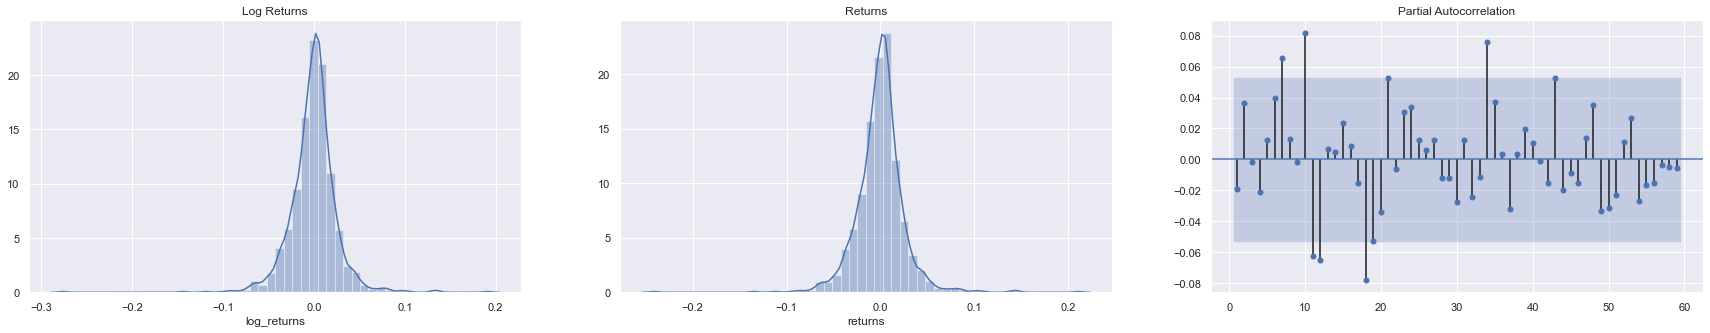

In [35]:
train_start = "01/01/2015" #when you want your training dataset to start
today = datetime.now().strftime("%d/%m/%Y") #today
#scrape(list(assets.values()),train_start,today) #download data from investing.com
# datasets

#read dataset from disk
fullpath = f"../data/{datasets.value} Historical Data.csv" 
swap = False
df = pd.read_csv(fullpath)[['Date','Price','High','Low']]
df = clean(df)

#add exogenous variables
exogenous = pd.read_csv('../data/US 10 Year T-Note Futures Historical Data.csv')
df['US_5_Year_Log_Returns'] = transformDF(clean(exogenous))[0].loc[:,'log_returns']

#prepare data for tree-based methods vs other methods respectively
df2, df3, normalizeFeats = transformDF(df, swap=swap)
statistics(df2)
df2 = df2.drop('returns',axis=1)
display(df2.tail())
display(df3.tail())

**PARAMETERS**
Parameters to set: 
+ **param:** what the model tries to forecast. 
    + **direction** - 0 or 1 for decrease, increase respectively (a probability) in close-to-close price (rate)
    + **log_returns** - Log-Change in close-to-close price (rate), > 0 means increase, < 0 means decrease
    + **Price**, **Rate** - next close price (rate)
    + **IntradayRange** - next np.log(High/Low), proxy for intraday vol
+ **train_end** - this will be when you want the backtest to start (and the end of training data)
+ **hyperParams** - model hyperparameters
+ **LAGS** - how much history (lookback window) to include

**Hyperparameters Framework**
+ Set **LAGS** according to the partial autocorrelation plot (see the chart in the cell above), select a lag that lies outside the confidence interval (shaded blue region)
+ If overfitting, select an earlier **train end**, this also increases the size of the backtest period and makes results more likely to be significant

**Models**

This  fits the training data to several models and produces graphs
+ XGBoost (xgb), CatBoost (cb) (Gradient Boosted Decision Trees) - learns a set of rules to predict target
+ Logistic Regression (Logit) / Linear Regression (linear_reg)
+ Deep Neural Network (dnn) - learns a function (joint distribution) between variables and target
+ Gaussian Process (gp) - learns a normal distribution over time to predict target
+ Ensemble - fits another on all model predictions and the true target

The general specification for the model

$ \hat y_{t+1} = f(x_{t},x_{t-1},... x_{t-L})$

Where $x_{t}$ is a vector of features, $x_{t} = (y_{t}, \text{log}(price),\text{log}(high),\text{log}(low), dateFeatures...)$ and $ y_{t+1} $ is the next day direction, returns etc.

In [8]:
param = 'direction' #what you want to forecast
train_end = "2020-03-09" #when you want to start backtesting (and end of training data)
hyperParams = {"cb":{"n_estimators":300, #no. of trees
                     "max_depth":5, #decision splits
                     "learning_rate":0.1}, #sum learning_rate * tree decision
               "xgb":{"n_estimators":300,
                      "max_depth":5,
                      "learning_rate":0.1},
               "ensemble":{"n_estimators":100, #combine your model predictions, wisdom of the crowds
                          "max_depth":1,
                           "learning_rate":0.01
                          },
               "dnn":{"hidden_units":64},
               'kmeans':{"n_clusters":8}
              }
LAGS = 24

**Output**

The output of running this cell is some **summary statistics of the models performance on the training and test dataset (backtest)**

+ For Regression (returns, it will be **R2** and **Mean Squared Error** 
+ For Classification it will be **Accuracy** - did it the uptrends correct and downtrends correct and **Receiving Operator Curve score** (how good are your predicted probabilities, shld have as close to 0 if its actually 0 and as close to 1 if its actually 1) 



**Trade Recommendation Framework**
1. Do the models have above 50% accuracy?
2. Which models have above 50% accuracy?
3. Which models lead to a good backtest result?
4. Do the best models have a consensus view?
5. Take the best model's forecast


If not either...
1. Change hyperparametes and run again (training size, model hyperparameters, lags)
2. Discard predictions for today

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


MODEL EVALUATION - TRAINING SET
--------------------
Model: cbc
Model: xgbc
Model: logit
Model: gpc
Model: dnn
Model: ensemble
--------------------

MODEL EVALUATION - TEST SET
--------------------
Model: cbc
Model: xgbc
Model: logit
Model: gpc
Model: ensemble
Model: dnn


,train_accuracy,train_f1_score,train_roc_auc,test_accuracy,test_f1_score,test_roc_auc,hyperParams
logit,0.600610,0.642077,0.619940,0.695652,0.588235,0.638462,NaN
gpc,0.908537,0.914773,0.967871,0.608696,0.526316,0.523077,NaN
cbc,1.000000,1.000000,1.000000,0.478261,0.538462,0.430769,"{""n_estimators"": 300, ""max_depth"": 5, ""learnin..."
xgbc,1.000000,1.000000,1.000000,0.434783,0.518519,0.476923,"{""n_estimators"": 300, ""max_depth"": 5, ""learnin..."
dnn,0.607470,0.699708,0.688744,0.434783,0.580645,0.630769,"{""hidden_units"": 64}"
ensemble,1.000000,1.000000,1.000000,0.347826,0.516129,0.442308,"{""n_estimators"": 100, ""max_depth"": 1, ""learnin..."


LAST DATE: 2020-04-09
----------
FORECAST PROBABILITY OF INCREASE IN PRICE (0 means price very likely to decrease, 1 very likely to increase) 
----------
XGBoost Classifier: 0.69721
CatBoost Classifier 0.62513
Logit: 0.59715
Deep Neural Network: 0.87551
Gaussian Process: 0.53226
Ensemble: 0.61812


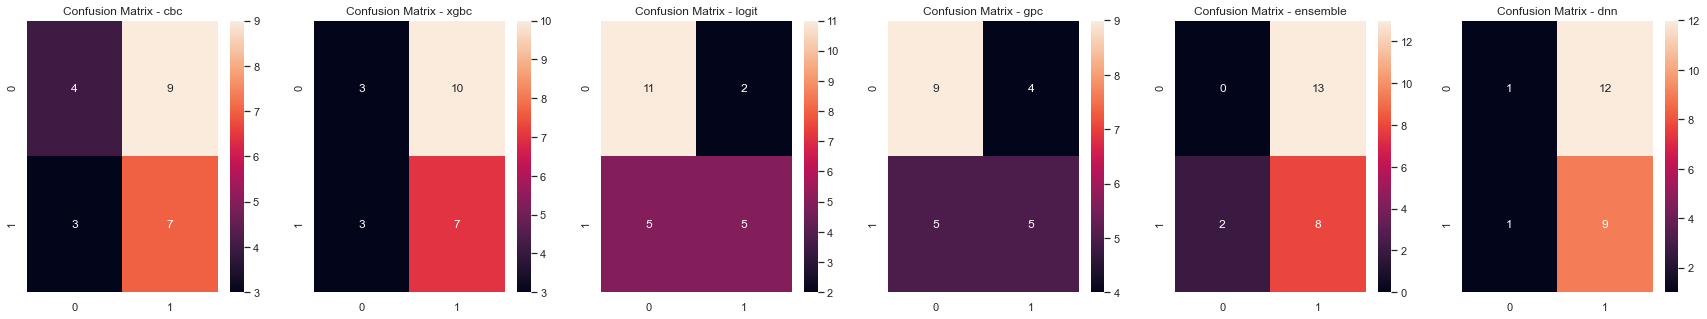

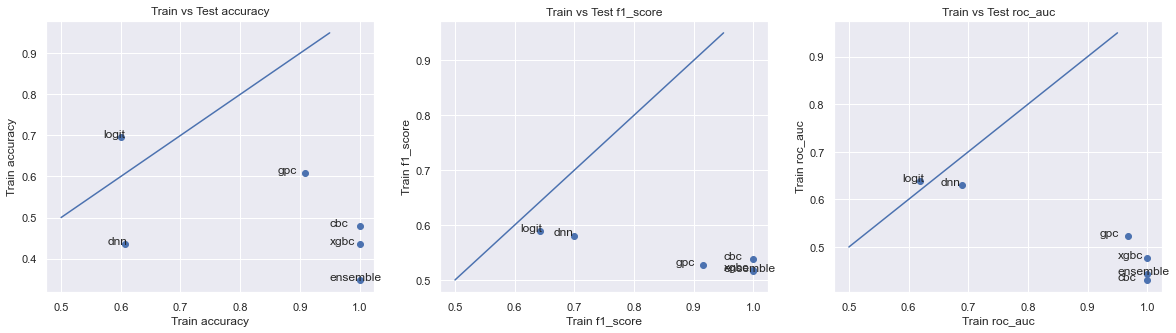

In [34]:
df4, df5 = addLaggedFeats(df2, df3, LAGS)
data_tree, data, models, fig3, fig4, logs3,ax = trainTestWrapper(df4, df5, 
                                                              train_end, param, 
                                                              normalizeFeats,hyperParams, LAGS)
fig3.show()
#fig4.show() if mode is regression
display(logs3)
ID = int(datetime.now().timestamp())
logs3.to_csv(f"trainPerformanceLog-{ID}.csv",index=False)

preds = recommendTrade(data_tree, data, models, param, swap=False)

modelHistory = modelHistoricPredsWriter(preds, datasets.value, ID, path="")

**Backtest**

The backtest offers more validation into whether the model predictions are useful

We backtest a simple trading rules: 
+ Direction - If the model is confident of a higher closing price, we long (payers), if confident of  lower we short (receivers), otherwise we go to cash. We require the model to have a level of a confidence, and we set risk limits (proportion of strategy capital in long/payers and short/receivers)
+ Returns, Price, log_returns - If the model forecasts an increase then long/payers, otherwise short/receivers

**We first backtest the performance of the strat across models and differing confidence levels**

Confidence means: 

Trade if $abs(\hat y_{t+1} -0.5) > confidence$

i.e. we require the model to be sufficiently confident of direction in order to trade, similar to a z-score for RV.

e.g. confidence = 0.4 means the model will trade for $\hat y_{t+1} < 0.3, \hat y_{t+1} > 0.7$

This can be a proxy for "what level of confidence is required" to trust the model

In [6]:
results = backtestLogger(models,data_tree,data,param, swap, ID, verbose=False,write=False)
results = isSwap(results, swap)
display(results)

BACKTEST SEARCHER
--------------------
PARAMS - Model: cbc, Confidence:-1
PARAMS - Model: cbc, Confidence:0
PARAMS - Model: cbc, Confidence:0.25
PARAMS - Model: cbc, Confidence:0.5
PARAMS - Model: cbc, Confidence:0.75
PARAMS - Model: cbc, Confidence:0.9
NO TRADES MADE
PARAMS - Model: logit, Confidence:-1
PARAMS - Model: logit, Confidence:0
PARAMS - Model: logit, Confidence:0.25
PARAMS - Model: logit, Confidence:0.5
PARAMS - Model: logit, Confidence:0.75
NO TRADES MADE
PARAMS - Model: logit, Confidence:0.9
NO TRADES MADE
PARAMS - Model: dnn, Confidence:-1
PARAMS - Model: dnn, Confidence:0
PARAMS - Model: dnn, Confidence:0.25
PARAMS - Model: dnn, Confidence:0.5
PARAMS - Model: dnn, Confidence:0.75
NO TRADES MADE
PARAMS - Model: dnn, Confidence:0.9
NO TRADES MADE
PARAMS - Model: ensemble, Confidence:-1
PARAMS - Model: ensemble, Confidence:0
PARAMS - Model: ensemble, Confidence:0.25
PARAMS - Model: ensemble, Confidence:0.5
PARAMS - Model: ensemble, Confidence:0.75
NO TRADES MADE
PARAMS - M

,totalPNL,meanPNL,sharpe,max_drawdown,volatility,sortino,winRate,meanTime,no_of_trades,bestTrade,worstTrade,totalReturn,meanReturn,alpha,wins,completedTrades,pVal,model,confidence_level
0,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.90
1,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.75
2,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,-1.00
3,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.50
4,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.25
5,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.00
6,32.128566,5.354761,-0.572135,-0.001564,0.000595,-0.896047,0.666667,1.0,6.0,15.919675,-15.721340,1.004267,1.000164,-0.018501,4.0,6.0,0.343750,ensemble,0.50
7,30.499412,2.346109,-0.053806,-0.002412,0.000844,-0.082848,0.692308,1.0,13.0,36.361745,-20.531516,1.004747,1.000183,-0.018020,9.0,13.0,0.133423,cbc,0.50
8,28.759454,1.307248,-0.891853,-0.001845,0.000719,-1.238267,0.478261,2.0,23.0,10.113617,-6.817910,1.003770,1.000145,-0.018998,11.0,22.0,0.584094,ensemble,0.00
9,28.309124,1.286778,-0.186367,-0.002347,0.000886,-0.274223,0.565217,1.0,23.0,20.795523,-18.920331,1.004550,1.000175,-0.018218,13.0,22.0,0.261734,cbc,0.00


# After finding the model + confidence that leads to the best backtest result 

We run the backtest again for the specific model for a futher deeper dive.


We can then visualise any trade given a valid trade ID in the tradeBook


You can set the following parameters:
+ **starting_cap** - Initial Capital
+ **longLimit** - limit on Longs as a proportion of strategy capital (between 0 or 1) 
+ **shortLimit** - limit on Shorts as a proportion of strategy capital (between 0 or 1) 
+ **longLimit** - limit on Longs as a proportion of strategy capital (between 0 or 1)
+ **confidence** - how sure you want to be of a forecast (between 0 or 1) or -1 for no sizing
+ **reinvest** - reinvest capital
+ **swap** - is it a swap
+ **write** - whether you want to output a record of trades
+ **path** - where you want to write your files to





In [53]:
#this runs a single backtest using your desired moel
backtestResults,tradeBook = backtest(models, data_tree, data, 
                           transaction_costs=0, starting_cap = 10000,
                           modelToUse='ensemble', param=param, swap=swap,
                            confidence=0.25, longLimit=1, shortLimit=-1,reinvest=False, 
                           write=False, path = "")

#
fig, fig2, summary = diagnoseBackTest(backtestResults, 
                                    tradeBook, 
                                    data['date_test'],
                                     swap=swap,starting_cap=10000,verbose=True)
fig.show()
fig2.show()
tradeBook2 = isSwap2(tradeBook,swap)
tradeBook

tradeBook
fig = tradeBookPlotter(2, tradeBook, data_tree)
fig.show()

BACKTEST SUMMARY
--------------------
UNITS: NOTATIONAL
Number of Trades: 12
WIN RATE: 50.00000% (Statistical Significance/ p-value : 0.6127929687499998) 
TOTAL PNL: 58.17 (0.00010021539455405859)
MEAN PNL per trade: 4.85 (0.00010001628830928052)
Maximum Drawdown: -3.84703 %
Volatility: 0.01129
Sharpe: -0.03165
Sortino: -0.05078
Alpha (excess on benchmark): 0.29816
Mean Duration of Trade: 1
Best Trade: 195.13 (0.02)
Worst Trade: -120.25 (0.02)
--------------------



**Shapley Values**
This is a way to explain how the model comes to a decision. It shows how the relative highness/lowness of a feature impacts the model output. It is useful particularly in the Neural Network (black box cases), if you want to get an explanation for how the model works. https://github.com/slundberg/shap

In [42]:
shapPlotter(models, 'cbc', data_tree,data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


**Feature Importances**

This is a way to explain how the model comes to a decision. It shows how much the model utilises a particular feature (variable) is utilised

array([<matplotlib.axes._subplots.AxesSubplot object at 0x156f409d0>,
      dtype=object)

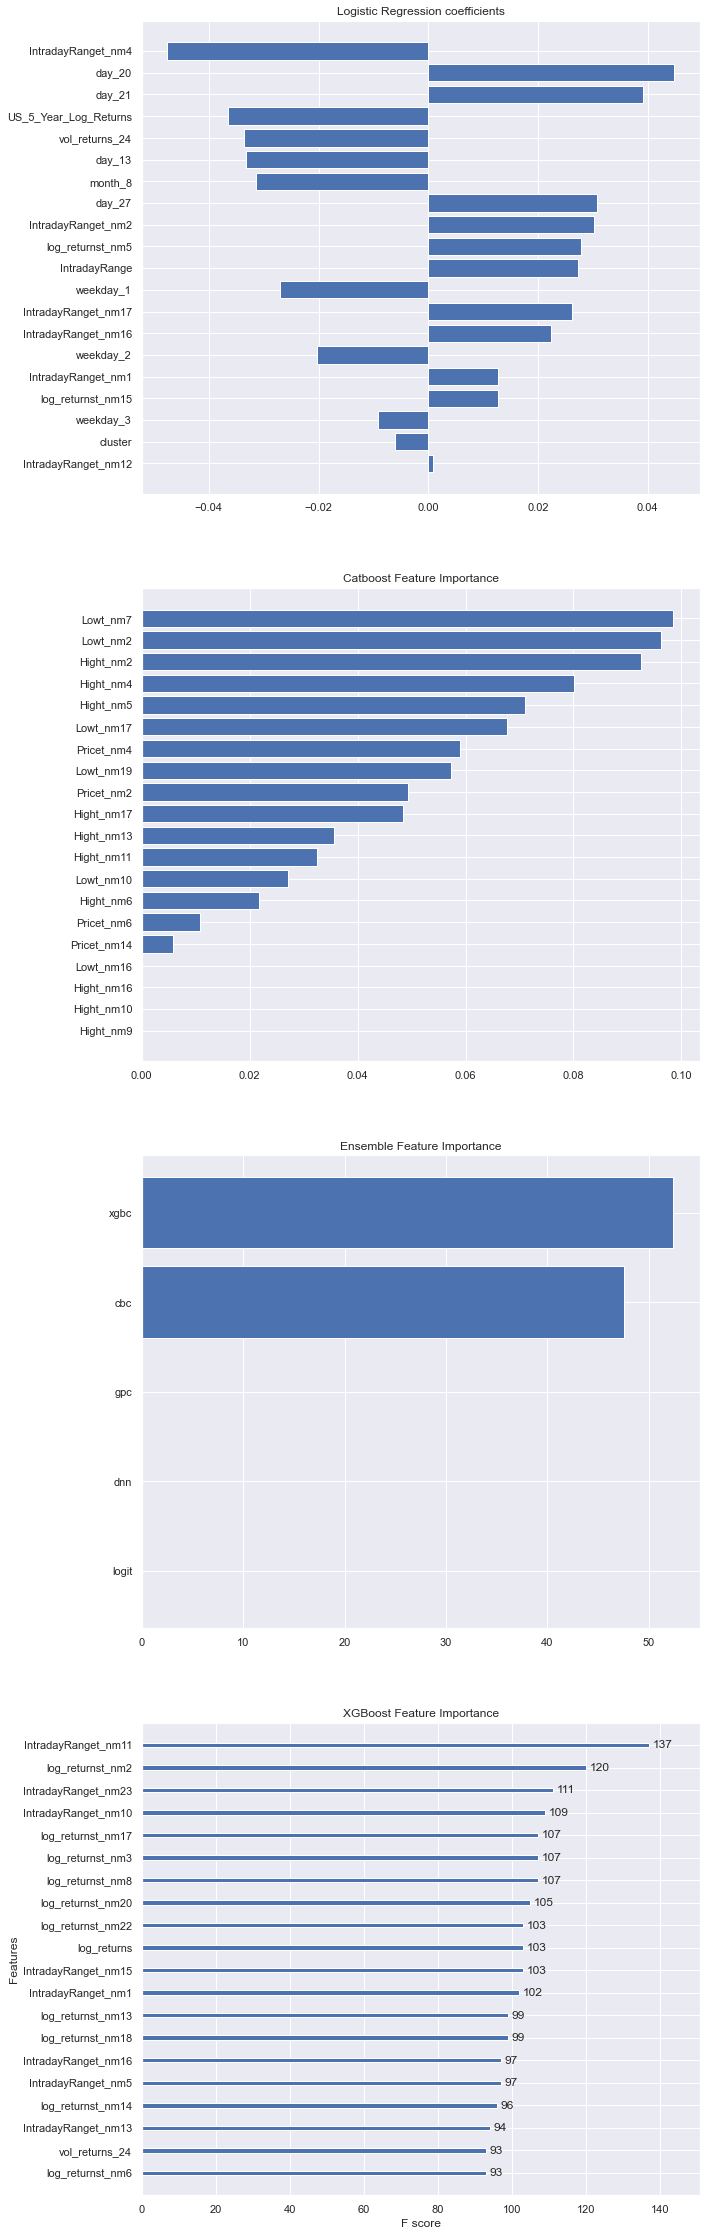

In [52]:
#feature importances
featImportances(models,data_tree, data, param)
#shapley values


# Bet Sizing = 2p-1 - This makes high conviction forecast downs full shorts; high conviction ups longs

# Dev
+ Hypothesis Testing on Means, Residuals, Test for Normality
+ Residual analysis
+ Add lagged indicators
+ Multiple Comparison Bias